In [210]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model


In [234]:
# creation of sample data
n = 10  # Number of observations
X = np.random.rand(n, 1) * 10  # Independent variable (random values between 0 and 10)
# True relationship
beta_0 = 5 
beta_1 = 2
beta_2 = 4
# Introduce some noise (errors)
errors = np.random.normal(0, 2, n)  # Normally distributed errors with mean 0 and std 2
Y = beta_0 + beta_1 * X.flatten()+ errors  # Dependent variable

Y2 = beta_0 + beta_1 * (X.flatten()**5)+ errors 

Y3 = beta_0 + beta_1 * X.flatten()+ beta_2*(2*X.flatten())+ errors


In [235]:
exp_config = {'normal': {'Y':Y, 'X':X},
              'non_linear':{'Y':Y2, 'X':X},
              'corr_variables': {'Y':Y3, 'X':np.concatenate((X, 2*X) , axis=1)}
              }


def ols_regression(X, y, intercept = True):
    intermed_steps = {}

    # Add intercept column if not already included
    if (not np.any(np.all(X==1, axis=0)) ) and intercept:
        X = np.column_stack((np.ones(X.shape[0]), X))
    intermed_steps['mod_X'] = X

    # Calculate (X^T X)^{-1} X^T y
    XtX = np.dot(X.T, X)
    intermed_steps['XtX'] = XtX
    det_XtX = np.abs(np.round(np.linalg.det(XtX),0))
    if det_XtX==0:
        print(det_XtX)
        XtX_inv = np.linalg.pinv(XtX)
    else:
        XtX_inv = np.linalg.inv(XtX)
        
    intermed_steps['XtX_inv'] = XtX_inv
    XtX_inv_Xt = np.dot(XtX_inv, X.T)
    intermed_steps['XtX_inv_Xt'] = XtX_inv_Xt
    beta = np.dot(XtX_inv_Xt, y)

    intermed_steps['X_XtX_inv_Xt'] = np.dot(intermed_steps['mod_X'], XtX_inv_Xt)
    
    return beta, intermed_steps


for exp_type, config in exp_config.items():
    beta, intermed_steps= ols_regression(config['X'], config['Y'])
    config['betas'] = beta
    config['intermed_steps'] = intermed_steps
    config['y_pred'] = np.dot(intermed_steps['mod_X'],beta )
    config['infl_points'] = np.diag(intermed_steps['X_XtX_inv_Xt'])

    LR_obj = linear_model.LinearRegression()
    LR_obj.fit(X=intermed_steps['mod_X'],y=config['Y'])
    
    config['skl_y_pred']= LR_obj.predict(intermed_steps['mod_X'])
    

0.0


In [240]:
infl_points_combined = {'exp_name': [],'inf_points':[],'point':[], 'X_val':[],'y_pred':[],'skl_y_pred':[]}

for exp_type, config in exp_config.items():
    infl_points_combined['exp_name']+=[exp_type]*len(config['infl_points'])
    infl_points_combined['inf_points']+=list(config['infl_points'])
    infl_points_combined['point']+= list(range(1,len(config['infl_points'])+1))
    infl_points_combined['X_val']+=list(config['X'][:,0])
    infl_points_combined['y_pred']+=list(config['y_pred'])
    infl_points_combined['skl_y_pred']+=list(config['skl_y_pred'])

infl_points_combined_df = pd.DataFrame(infl_points_combined)


<Axes: xlabel='point', ylabel='inf_points'>

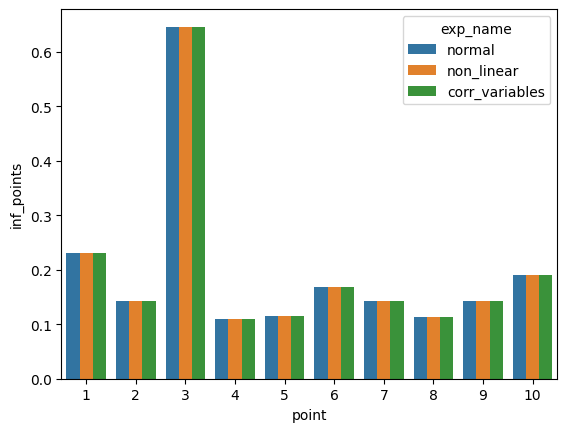

In [206]:
sns.barplot(data=infl_points_combined_df,x='point', y='inf_points',hue='exp_name')

[5.76337316 6.5679984  1.90173213 0.04584066 6.48324146 5.66600008
 0.11530211 0.60182931 9.42556337 5.38652282]
[5.76337316 6.5679984  1.90173213 0.04584066 6.48324146 5.66600008
 0.11530211 0.60182931 9.42556337 5.38652282]
[5.76337316 6.5679984  1.90173213 0.04584066 6.48324146 5.66600008
 0.11530211 0.60182931 9.42556337 5.38652282]


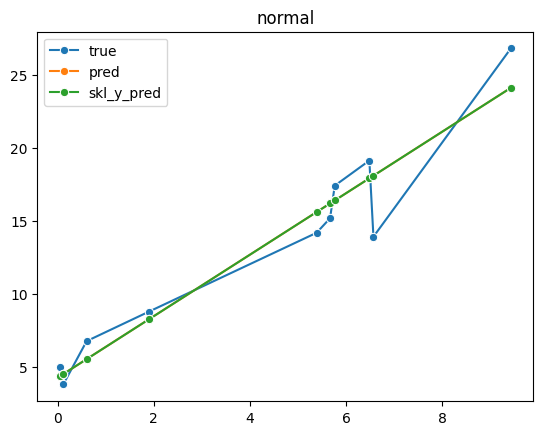

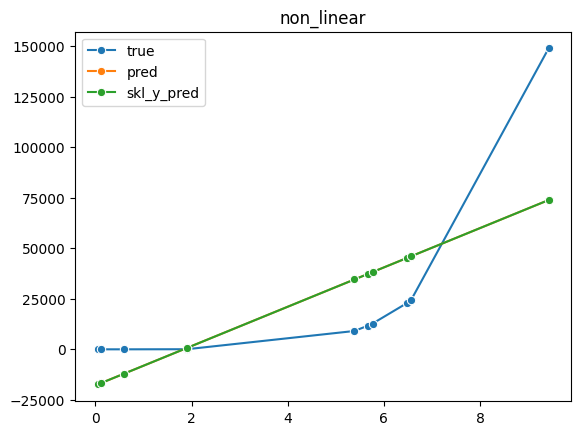

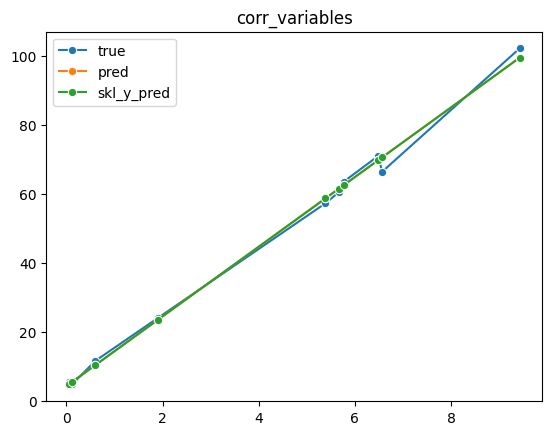

In [245]:
for exp_type, config in exp_config.items():
    print(config['X'][:,0].flatten())
    plt.figure()
    sns.lineplot(x=config['X'][:,0].flatten(), y=config['Y'], label = 'true', marker='o')
    sns.lineplot(x=config['X'][:,0].flatten(), y=config['y_pred'],label ='pred', marker='o')
    sns.lineplot(x=config['X'][:,0].flatten(), y=config['skl_y_pred'],label ='skl_y_pred', marker='o')
    plt.title(exp_type)